In [505]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import plotly.offline as pyoff
import plotly as py
import plotly.graph_objs as go
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
pyoff.init_notebook_mode()
from plotly.offline import init_notebook_mode, iplot
py.offline.init_notebook_mode(connected=True) 
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.svm import SVC
from mlxtend.frequent_patterns import apriori, association_rules
import random
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [664]:
#%time sales = pd.read_csv("data/Water_System_14-19.csv")
#%time sales = pd.read_csv("data/Pump_industry_14-19.csv")
%time sales = pd.read_csv("data/wholesale_14-19.csv")


Wall time: 6.55 s


In [665]:
sales=sales.sort_values(by=['Date'])
sales_copy=sales

In [523]:
sales.head(2)

Date          OrderNumber  OrderLineNumber  Quantity   SellPrice  \
0   01/02/2014  order_number_256262               10         1     2.66666   
25  01/02/2014   order_number_80342               10         1  4666.65500   

          CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0   ccn_75546  partner_number_80756  mat_2839    item_cat_grp_6  item_cat_13   
25  ccn_56484  partner_number_53844  mat_3690    item_cat_grp_3   item_cat_5   

    ... Region     SubRegion                   Industry   IndustryGroup  \
0   ...    EMA  Europe South  PUMPS & PUMPING EQUIPMENT  OEM INDUSTRIES   
25  ...    NaN     Northeast  PUMPS & PUMPING EQUIPMENT  OEM INDUSTRIES   

         Plant   PlantType     PlantPlatform            Market MonthYear  \
0   Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   
25      Vernon  Unassigned  plant_platform_0  General Industry   01/2014   

   Column 32  
0       2014  
25      2014  

[2 rows x 32 columns]

### Associations within and across various part product families and customers

In [524]:
# Let's  find out the association between items, so we can offer items in case one of the item was ordered, or offer bundles

In [525]:
#let's check how many orders we have
sales['OrderNumber'].unique

<bound method Series.unique of 0         order_number_256262
25         order_number_80342
23        order_number_178626
22        order_number_171772
21         order_number_20206
                 ...         
776930    order_number_203616
776931     order_number_46133
776932    order_number_203616
776922    order_number_203616
777121    order_number_203616
Name: OrderNumber, Length: 832979, dtype: object>

In [526]:
#frequencies of ItemDescription

fs_freq_item=sales.groupby(['ItemDescription']).size().reset_index(name='Frequency')
fs_freq_item=fs_freq_item.sort_values(by=['Frequency'], ascending =[False])
a=fs_freq_item.head(20)
ax = a.plot(kind='barh', x='ItemDescription', y='Frequency',figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

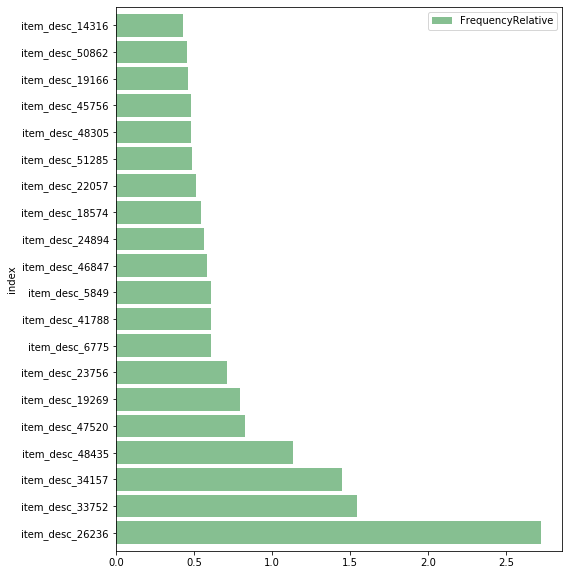

In [527]:
# relative frequencies of ItemDescription

a=sales['ItemDescription'].value_counts(True).reset_index(name='FrequencyRelative')
a['FrequencyRelative']=a['FrequencyRelative']*100
b=a.sort_values(by=['FrequencyRelative'], ascending =[False])
ab=b.head(20)
ax = ab.plot(kind='barh', x='index', y='FrequencyRelative',figsize=(8, 10), color='#86bf91', zorder=2,width=0.85)

In [528]:
#get table with counts per ItemDescription each row is order number and colimns is count of items fot that order
fs_ON = (sales.groupby(['OrderNumber', 'ItemDescription'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('OrderNumber')) 
fs_ON.head(5)

ItemDescription      item_desc_10005  item_desc_10007  item_desc_10013  \
OrderNumber                                                              
order_number_100015              0.0              0.0              0.0   
order_number_10002               0.0              0.0              0.0   
order_number_100020              0.0              0.0              0.0   
order_number_100026              0.0              0.0              0.0   
order_number_100031              0.0              0.0              0.0   

ItemDescription      item_desc_10017  item_desc_10020  item_desc_10022  \
OrderNumber                                                              
order_number_100015              0.0              0.0              0.0   
order_number_10002               0.0              0.0              0.0   
order_number_100020              0.0              0.0              0.0   
order_number_100026              0.0              0.0              0.0   
order_number_100031              0.0              0.0              0.0   

ItemDescription      item_desc_10024  item_desc_10028  item_desc_10033  \
OrderNumber                                                              
order_number_100015              0.0              0.0              0.0   
order_number_10002               0.0              0.0              0.0   
order_number_100020              0.0              0.0              0.0   
order_number_100026              0.0              0.0              0.0   
order_number_100031              0.0              0.0              0.0   

ItemDescription      item_desc_10034  ...  item_desc_994  item_desc_995  \
OrderNumber                           ...                                 
order_number_100015              0.0  ...            0.0            0.0   
order_number_10002               0.0  ...            0.0            0.0   
order_number_100020              0.0  ...            0.0            0.0   
order_number_100026              0.0  ...            0.0            0.0   
order_number_100031              0.0  ...            0.0            0.0   

ItemDescription      item_desc_9959  item_desc_9961  item_desc_9970  \
OrderNumber                                                           
order_number_100015             0.0             0.0             0.0   
order_number_10002              0.0             0.0             0.0   
order_number_100020             0.0             0.0             0.0   
order_number_100026             0.0             0.0             0.0   
order_number_100031             0.0             0.0             0.0   

ItemDescription      item_desc_9973  item_desc_9977  item_desc_9984  \
OrderNumber                                                           
order_number_100015             0.0             0.0             0.0   
order_number_10002              0.0             0.0             0.0   
order_number_100020             0.0             0.0             0.0   
order_number_100026             0.0             0.0             0.0   
order_number_100031             0.0             0.0             0.0   

ItemDescription      item_desc_9993  item_desc_9999  
OrderNumber                                          
order_number_100015             0.0             0.0  
order_number_10002              0.0             0.0  
order_number_100020             0.0             0.0  
order_number_100026             0.0             0.0  
order_number_100031             0.0             0.0  

[5 rows x 11338 columns]

In [529]:
# function to convert cound to 1 or 0
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1

In [530]:
# Encoding the datasets 
fs_ON_encoded = fs_ON.applymap(hot_encode) 
fs_ON = fs_ON_encoded 
fs_ON.head(5)

ItemDescription      item_desc_10005  item_desc_10007  item_desc_10013  \
OrderNumber                                                              
order_number_100015                0                0                0   
order_number_10002                 0                0                0   
order_number_100020                0                0                0   
order_number_100026                0                0                0   
order_number_100031                0                0                0   

ItemDescription      item_desc_10017  item_desc_10020  item_desc_10022  \
OrderNumber                                                              
order_number_100015                0                0                0   
order_number_10002                 0                0                0   
order_number_100020                0                0                0   
order_number_100026                0                0                0   
order_number_100031                0                0                0   

ItemDescription      item_desc_10024  item_desc_10028  item_desc_10033  \
OrderNumber                                                              
order_number_100015                0                0                0   
order_number_10002                 0                0                0   
order_number_100020                0                0                0   
order_number_100026                0                0                0   
order_number_100031                0                0                0   

ItemDescription      item_desc_10034  ...  item_desc_994  item_desc_995  \
OrderNumber                           ...                                 
order_number_100015                0  ...              0              0   
order_number_10002                 0  ...              0              0   
order_number_100020                0  ...              0              0   
order_number_100026                0  ...              0              0   
order_number_100031                0  ...              0              0   

ItemDescription      item_desc_9959  item_desc_9961  item_desc_9970  \
OrderNumber                                                           
order_number_100015               0               0               0   
order_number_10002                0               0               0   
order_number_100020               0               0               0   
order_number_100026               0               0               0   
order_number_100031               0               0               0   

ItemDescription      item_desc_9973  item_desc_9977  item_desc_9984  \
OrderNumber                                                           
order_number_100015               0               0               0   
order_number_10002                0               0               0   
order_number_100020               0               0               0   
order_number_100026               0               0               0   
order_number_100031               0               0               0   

ItemDescription      item_desc_9993  item_desc_9999  
OrderNumber                                          
order_number_100015               0               0  
order_number_10002                0               0  
order_number_100020               0               0  
order_number_100026               0               0  
order_number_100031               0               0  

[5 rows x 11338 columns]

In [539]:
# create assocition with support > 0.001 using apriori algorithm
frq_items = apriori(fs_ON, min_support = 0.01, use_colnames = True)
frq_items.sort_values(by=['support'], ascending =[False]).head(10)

support           itemsets
18  0.047674  (item_desc_34157)
12  0.046396  (item_desc_26236)
17  0.043073  (item_desc_33752)
32  0.028758   (item_desc_5849)
11  0.024859  (item_desc_24894)
9   0.023773  (item_desc_23756)
29  0.022303  (item_desc_48435)
24  0.021345  (item_desc_41788)
31  0.021281  (item_desc_51285)
1   0.019683  (item_desc_14316)

In [540]:
# create rules using "lift as a metric and thershold=1 "
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print("Rules amount : " , len(rules))
rules.head(10)

Rules amount :  228


antecedents  \
68                   (item_desc_6775, item_desc_41788)   
142  (item_desc_6775, item_desc_41788, item_desc_22...   
170  (item_desc_6775, item_desc_41788, item_desc_48...   
200  (item_desc_6775, item_desc_41788, item_desc_22...   
38                  (item_desc_41788, item_desc_22057)   
145  (item_desc_41788, item_desc_22057, item_desc_1...   
129  (item_desc_41788, item_desc_22057, item_desc_4...   
198  (item_desc_41788, item_desc_22057, item_desc_1...   
149                 (item_desc_41788, item_desc_22057)   
100                 (item_desc_41788, item_desc_22057)   

                           consequents  antecedent support  \
68                   (item_desc_18574)            0.012334   
142                  (item_desc_18574)            0.010353   
170                  (item_desc_18574)            0.011950   
200                  (item_desc_18574)            0.010161   
38                   (item_desc_18574)            0.010481   
145                   (item_desc_6775)            0.010417   
129                  (item_desc_18574)            0.010289   
198                   (item_desc_6775)            0.010225   
149  (item_desc_6775, item_desc_18574)            0.010481   
100                   (item_desc_6775)            0.010481   

     consequent support   support  confidence       lift  leverage  conviction  
68             0.015849  0.012334    1.000000  63.096774  0.012138         inf  
142            0.015849  0.010353    1.000000  63.096774  0.010189         inf  
170            0.015849  0.011950    1.000000  63.096774  0.011761         inf  
200            0.015849  0.010161    1.000000  63.096774  0.010000         inf  
38             0.015849  0.010417    0.993902  62.712038  0.010251  161.400818  
145            0.015976  0.010353    0.993865  62.208000  0.010186  160.395833  
129            0.015849  0.010225    0.993789  62.704869  0.010062  158.448364  
198            0.015976  0.010161    0.993750  62.200800  0.009998  157.443763  
149            0.013420  0.010353    0.987805  73.605575  0.010212   80.899540  
100            0.015976  0.010353    0.987805  61.828683  0.010185   80.689928

In [541]:
# fumction to plot the rules :

def draw_graph(rules, rules_to_show):
    import networkx as nx  
    G1 = nx.DiGraph()
    plt.figure(1,figsize=(15,10))
    color_map=[]
    N = 50
    colors = np.random.rand(N)    
    strs=['R1', 'R2',  'R3', 'R4', 'R5','R6', 'R7', 'R8', 'R9','R10']   
    
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])
    
        for a in rules.iloc[i]['antecedents']:

            G1.add_nodes_from([a])

            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)

        for c in rules.iloc[i]['consequents']:

            G1.add_nodes_from([c])

            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)            
  
            
    for node in G1:
        found_a_string = False

        for item in strs: 
            if node==item:
                found_a_string = True

        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green') 

        
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
 
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=20, with_labels=False)            
   
    for p in pos:  # raise text positions
        pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
 
    plt.show()

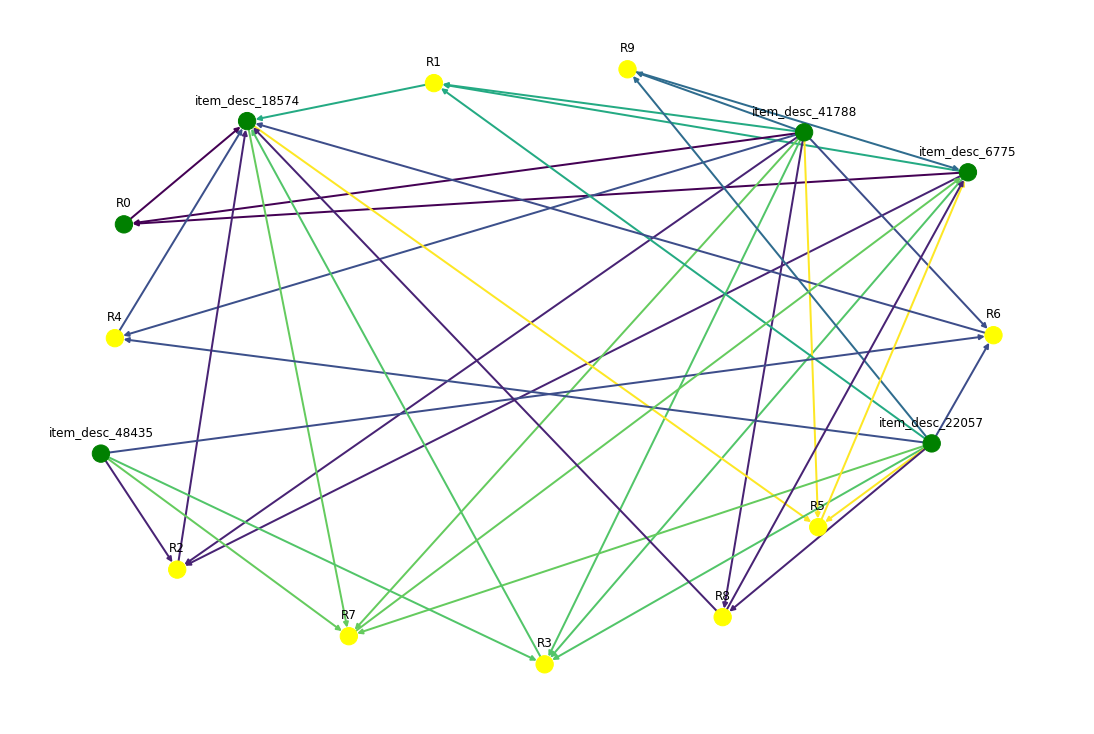

In [542]:
# Draw top 10 rules
draw_graph(rules, 10)

In [543]:
# next let find association between customers that buying the same items, so we can offer product to customer 
#with the same interset.


In [544]:
#get table with counts per ItemDescription
fs_ON_cust = (sales.groupby([ 'ItemDescription','CustId'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('ItemDescription')) 
fs_ON_cust.head(5)

CustId           cust_id_1000  cust_id_1046  cust_id_1063  cust_id_1088  \
ItemDescription                                                           
item_desc_10005           0.0           0.0           0.0           0.0   
item_desc_10007           0.0           0.0           0.0           0.0   
item_desc_10013           0.0           0.0           0.0           0.0   
item_desc_10017           0.0           0.0           0.0           0.0   
item_desc_10020           0.0           0.0           0.0           0.0   

CustId           cust_id_1090  cust_id_1125  cust_id_118  cust_id_1199  \
ItemDescription                                                          
item_desc_10005           0.0           0.0          0.0           0.0   
item_desc_10007           0.0           0.0          0.0           0.0   
item_desc_10013           0.0           0.0          0.0           0.0   
item_desc_10017           0.0           0.0          0.0           0.0   
item_desc_10020           0.0           0.0          0.0           0.0   

CustId           cust_id_1216  cust_id_1234  ...  cust_id_651  cust_id_683  \
ItemDescription                              ...                             
item_desc_10005           0.0           0.0  ...          0.0          0.0   
item_desc_10007           0.0           0.0  ...          0.0          0.0   
item_desc_10013           0.0           0.0  ...          0.0          0.0   
item_desc_10017           0.0           0.0  ...          0.0          0.0   
item_desc_10020           0.0           0.0  ...          0.0          0.0   

CustId           cust_id_712  cust_id_776  cust_id_838  cust_id_894  \
ItemDescription                                                       
item_desc_10005          0.0          0.0          0.0          0.0   
item_desc_10007          0.0          0.0          0.0          0.0   
item_desc_10013          0.0          0.0          0.0          0.0   
item_desc_10017          0.0          0.0          0.0          0.0   
item_desc_10020          0.0          0.0          0.0          0.0   

CustId           cust_id_910  cust_id_942  cust_id_96  cust_id_993  
ItemDescription                                                     
item_desc_10005          0.0          0.0         0.0          0.0  
item_desc_10007          0.0          0.0         0.0          0.0  
item_desc_10013          0.0          0.0         0.0          0.0  
item_desc_10017          0.0          0.0         0.0          0.0  
item_desc_10020          0.0          0.0         0.0          0.0  

[5 rows x 123 columns]

In [545]:
# Encoding the datasets 
fs_ON_cust_encoded = fs_ON_cust.applymap(hot_encode) 
fs_ON_cust = fs_ON_cust_encoded 
fs_ON_cust.head(5)

CustId           cust_id_1000  cust_id_1046  cust_id_1063  cust_id_1088  \
ItemDescription                                                           
item_desc_10005             0             0             0             0   
item_desc_10007             0             0             0             0   
item_desc_10013             0             0             0             0   
item_desc_10017             0             0             0             0   
item_desc_10020             0             0             0             0   

CustId           cust_id_1090  cust_id_1125  cust_id_118  cust_id_1199  \
ItemDescription                                                          
item_desc_10005             0             0            0             0   
item_desc_10007             0             0            0             0   
item_desc_10013             0             0            0             0   
item_desc_10017             0             0            0             0   
item_desc_10020             0             0            0             0   

CustId           cust_id_1216  cust_id_1234  ...  cust_id_651  cust_id_683  \
ItemDescription                              ...                             
item_desc_10005             0             0  ...            0            0   
item_desc_10007             0             0  ...            0            0   
item_desc_10013             0             0  ...            0            0   
item_desc_10017             0             0  ...            0            0   
item_desc_10020             0             0  ...            0            0   

CustId           cust_id_712  cust_id_776  cust_id_838  cust_id_894  \
ItemDescription                                                       
item_desc_10005            0            0            0            0   
item_desc_10007            0            0            0            0   
item_desc_10013            0            0            0            0   
item_desc_10017            0            0            0            0   
item_desc_10020            0            0            0            0   

CustId           cust_id_910  cust_id_942  cust_id_96  cust_id_993  
ItemDescription                                                     
item_desc_10005            0            0           0            0  
item_desc_10007            0            0           0            0  
item_desc_10013            0            0           0            0  
item_desc_10017            0            0           0            0  
item_desc_10020            0            0           0            0  

[5 rows x 123 columns]

In [546]:
# create assocition with support > 0.001
frq_items_cust = apriori(fs_ON_cust, min_support = 0.01, use_colnames = True)
frq_items_cust.head(10)

support        itemsets
0  0.010496  (cust_id_1246)
1  0.014200  (cust_id_1310)
2  0.015170  (cust_id_1589)
3  0.162992  (cust_id_1697)
4  0.042600  (cust_id_1841)
5  0.012701  (cust_id_1873)
6  0.073911  (cust_id_1879)
7  0.019316   (cust_id_189)
8  0.010407  (cust_id_1943)
9  0.062709  (cust_id_2029)

In [547]:
rules_cust = association_rules(frq_items_cust, metric ="lift", min_threshold = 1) 
rules_cust = rules_cust.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules_cust.head(10))
rules_cust=rules_cust.head(10)

                                    antecedents     consequents  \
841   (cust_id_560, cust_id_2029, cust_id_4147)  (cust_id_2171)   
824   (cust_id_2585, cust_id_560, cust_id_2029)  (cust_id_2171)   
798  (cust_id_2585, cust_id_2029, cust_id_4147)  (cust_id_2171)   
332                 (cust_id_560, cust_id_2029)  (cust_id_2171)   
782  (cust_id_2029, cust_id_2130, cust_id_4147)  (cust_id_2171)   
812  (cust_id_2585, cust_id_2029, cust_id_4241)  (cust_id_2171)   
910  (cust_id_2585, cust_id_4147, cust_id_4241)  (cust_id_2171)   
924   (cust_id_2585, cust_id_560, cust_id_4147)  (cust_id_2171)   
214                 (cust_id_1697, cust_id_712)  (cust_id_3827)   
290                (cust_id_2161, cust_id_2029)  (cust_id_2171)   

     antecedent support  consequent support   support  confidence      lift  \
841            0.010584            0.118804  0.010055    0.950000  7.996362   
824            0.011201            0.118804  0.010319    0.921260  7.754450   
798            0.012965  

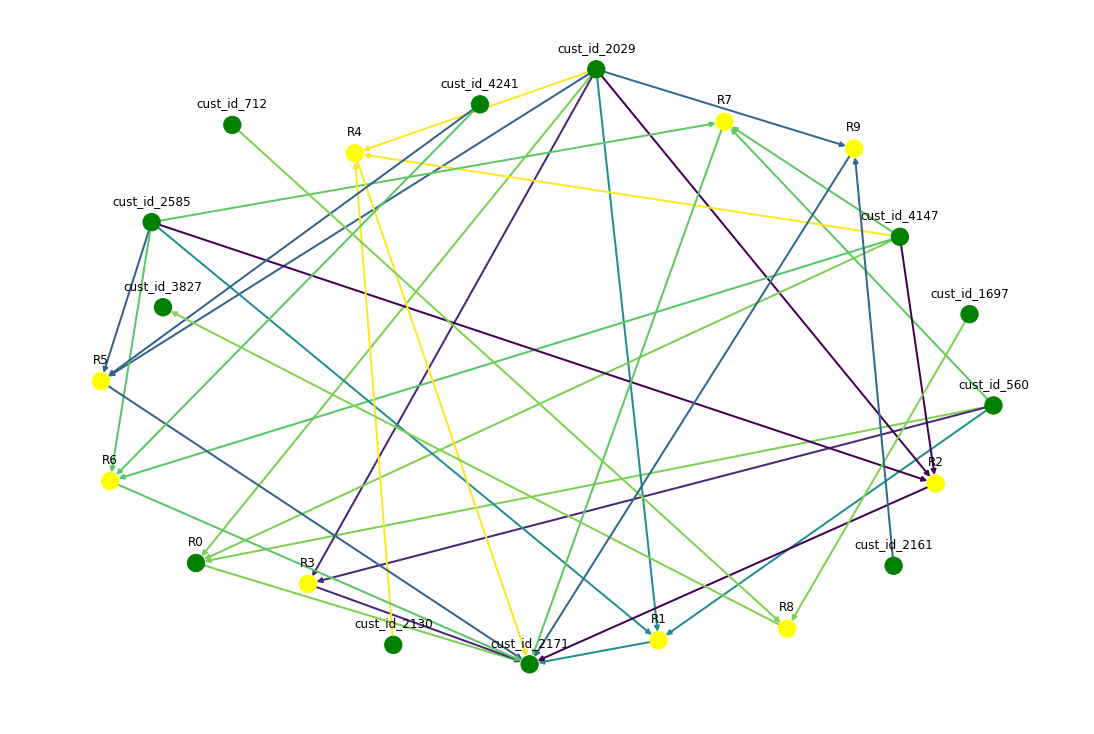

In [548]:
draw_graph(rules_cust, 10)

### Predict future purchases of various parts for customers

### EDA

In [666]:
#RFM calculation

#converting the type of Invoice Date Field from string to datetime.
sales['Date'] = pd.to_datetime(sales['Date'])

#creating YearMonth field for the ease of reporting and visualization
sales['InvoiceYearMonth'] = sales['Date'].map(lambda date: 100*date.year + date.month)

#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
sales['Revenue'] = sales['SellPrice'] * sales['Quantity']

fs_revenue = sales.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()

#X and Y axis inputs for Plotly graph. We use Scatter for line graphs
plot_data = [
    go.Scatter(
        x=fs_revenue['InvoiceYearMonth'],
        y=fs_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [667]:
#Calculate monthly change in percantage (pct_change)

fs_revenue['MonthlyGrowth'] = fs_revenue['Revenue'].pct_change()*100

#visualization - line graph
plot_data = [
    go.Scatter(
        x=fs_revenue.query("InvoiceYearMonth < 201912")['InvoiceYearMonth'],
        y=fs_revenue.query("InvoiceYearMonth < 201912")['MonthlyGrowth'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Growth Rate'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [668]:
# count customers ID's for each month
fs_monthly_active = sales.groupby('InvoiceYearMonth')['CustId'].nunique().reset_index()

#ax = fs_monthly_active.plot.bar(x='InvoiceYearMonth', y='CustId', rot=0, figsize=(20, 6))

plot_data = [
    go.Bar(
        x=fs_monthly_active['InvoiceYearMonth'],
        y=fs_monthly_active['CustId'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Active Customers'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [669]:
# number of orders for each month

fs_monthly_active = sales.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()

#ax = fs_monthly_active.plot.bar(x='InvoiceYearMonth', y='Quantity', rot=0, figsize=(20, 6))

plot_data = [
    go.Bar(
        x=fs_monthly_active['InvoiceYearMonth'],
        y=fs_monthly_active['Quantity'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Number of Orders'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [670]:
# average revenue for each month 

fs_monthly_active = sales.groupby('InvoiceYearMonth')['Revenue'].mean().reset_index()

#ax = fs_monthly_active.plot.bar(x='InvoiceYearMonth', y='Revenue', rot=0, figsize=(20, 6))

#plot the bar chart
plot_data = [
    go.Bar(
        x=fs_monthly_active['InvoiceYearMonth'],
        y=fs_monthly_active['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Order Average'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [671]:
#create a dataframe contaning CustomerID and first purchase date

fs_min_purchase = sales.groupby('CustId').Date.min().reset_index()
fs_min_purchase.columns = ['CustId','MinPurchaseDate']
fs_min_purchase['MinPurchaseYearMonth'] = fs_min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)
fs_min_purchase

#merge first purchase date column to our main dataframe
sales = pd.merge(sales, fs_min_purchase, on='CustId')
sales.head(5)

Date          OrderNumber  OrderLineNumber  Quantity   SellPrice  \
0 2014-01-02  order_number_194969               80         1  1009.33081   
1 2014-01-02  order_number_105429              180         1    55.99986   
2 2014-01-02  order_number_105429              180         1  1847.99538   
3 2014-01-02  order_number_105429              180         1   459.99885   
4 2014-01-02  order_number_105429              180         1    33.33325   

         CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0   ccn_3895  partner_number_98261  mat_3374    item_cat_grp_1   item_cat_8   
1  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
2  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
3  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
4  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   

   ...       Plant   PlantType     PlantPlatform            Market MonthYear  \
0  ...  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   
1  ...  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   
2  ...  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   
3  ...  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   
4  ...  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   

  Column 32 InvoiceYearMonth     Revenue MinPurchaseDate MinPurchaseYearMonth  
0      2014           201401  1009.33081      2014-01-02               201401  
1      2014           201401    55.99986      2014-01-02               201401  
2      2014           201401  1847.99538      2014-01-02               201401  
3      2014           201401   459.99885      2014-01-02               201401  
4      2014           201401    33.33325      2014-01-02               201401  

[5 rows x 36 columns]

In [672]:
#create a column called User Type and assign New or Existing 

sales['UserType'] = 'New'
sales.loc[sales['InvoiceYearMonth']>sales['MinPurchaseYearMonth'],'UserType'] = 'Existing'
sales.head(5)

Date          OrderNumber  OrderLineNumber  Quantity   SellPrice  \
0 2014-01-02  order_number_194969               80         1  1009.33081   
1 2014-01-02  order_number_105429              180         1    55.99986   
2 2014-01-02  order_number_105429              180         1  1847.99538   
3 2014-01-02  order_number_105429              180         1   459.99885   
4 2014-01-02  order_number_105429              180         1    33.33325   

         CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0   ccn_3895  partner_number_98261  mat_3374    item_cat_grp_1   item_cat_8   
1  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
2  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
3  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
4  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   

   ...   PlantType     PlantPlatform            Market MonthYear Column 32  \
0  ...  Unassigned  plant_platform_1  General Industry   01/2014      2014   
1  ...  Unassigned  plant_platform_1  General Industry   01/2014      2014   
2  ...  Unassigned  plant_platform_1  General Industry   01/2014      2014   
3  ...  Unassigned  plant_platform_1  General Industry   01/2014      2014   
4  ...  Unassigned  plant_platform_1  General Industry   01/2014      2014   

  InvoiceYearMonth     Revenue MinPurchaseDate MinPurchaseYearMonth UserType  
0           201401  1009.33081      2014-01-02               201401      New  
1           201401    55.99986      2014-01-02               201401      New  
2           201401  1847.99538      2014-01-02               201401      New  
3           201401   459.99885      2014-01-02               201401      New  
4           201401    33.33325      2014-01-02               201401      New  

[5 rows x 37 columns]

In [673]:
#calculate the Revenue per month for each user type
fs_user_type_revenue = sales.groupby(['InvoiceYearMonth','UserType'])['Revenue'].sum().reset_index()
fs_user_type_revenue.head(5)

InvoiceYearMonth  UserType       Revenue
0            201401       New  2.008806e+07
1            201402  Existing  2.529167e+07
2            201402       New  6.707103e+05
3            201403  Existing  2.757499e+07
4            201403       New  1.426036e+05

In [674]:
plot_data = [
    go.Scatter(
        x=fs_user_type_revenue.query("UserType == 'Existing'")['InvoiceYearMonth'],
        y=fs_user_type_revenue.query("UserType == 'Existing'")['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x=fs_user_type_revenue.query("UserType == 'New'")['InvoiceYearMonth'],
        y=fs_user_type_revenue.query("UserType == 'New'")['Revenue'],
        name = 'New'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New vs Existing'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [675]:
#create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)

fs_user_ratio = sales.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustId'].nunique()/sales.query("UserType == 'Existing'").groupby(['InvoiceYearMonth'])['CustId'].nunique() 
fs_user_ratio = fs_user_ratio.reset_index()
fs_user_ratio = fs_user_ratio.dropna()

#<1 - existing more

#plot the result

plot_data = [
    go.Bar(
        x=fs_user_ratio.query("InvoiceYearMonth>201501 and InvoiceYearMonth<201912")['InvoiceYearMonth'],
        y=fs_user_ratio.query("InvoiceYearMonth>201501 and InvoiceYearMonth<201912")['CustId'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New Customer Ratio'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [676]:
#Retention calculation :
#Monthly Retention Rate = Retained Customers From Prev. Month/Active Customers Total
#create retention matrix with crosstab
fs_retention = pd.crosstab(fs_user_purchase['CustId'], fs_user_purchase['InvoiceYearMonth']).reset_index()

fs_retention.head(5)

InvoiceYearMonth        CustId  201401  201402  201403  201404  201405  \
0                 cust_id_1037       0       0       0       0       0   
1                 cust_id_1044       1       0       0       0       0   
2                 cust_id_1072       0       0       0       0       0   
3                 cust_id_1110       0       0       0       0       0   
4                 cust_id_1140       0       0       0       0       0   

InvoiceYearMonth  201406  201407  201408  201409  ...  201808  201809  201810  \
0                      0       0       0       0  ...       0       0       0   
1                      0       0       0       0  ...       0       0       0   
2                      0       0       0       0  ...       0       0       0   
3                      0       0       0       0  ...       0       0       0   
4                      0       0       0       0  ...       0       0       0   

InvoiceYearMonth  201811  201812  201901  201902  201903  201904  201905  
0                      0       0       0       0       0       0       0  
1                      0       0       0       0       0       0       0  
2                      1       0       0       0       0       0       0  
3                      0       0       0       0       0       0       0  
4                      0       0       0       0       0       0       0  

[5 rows x 66 columns]

In [677]:
#create an array of dictionary which keeps Retained & Total User count for each month
#customer bought in 2 consequencs months

months = fs_retention.columns[2:]
retention_array = []

for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = fs_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = fs_retention[(fs_retention[selected_month]>0) & (fs_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
fs_retention = pd.DataFrame(retention_array)
fs_retention['RetentionRate'] = fs_retention['RetainedUserCount']/fs_retention['TotalUserCount']

#plot the retention rate graph
plot_data = [
    go.Scatter(
        x=fs_retention.query("InvoiceYearMonth<201912")['InvoiceYearMonth'],
        y=fs_retention.query("InvoiceYearMonth<201912")['RetentionRate'],
        name="organic"
    )
    
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Retention Rate'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [678]:
#create our retention table again with crosstab() - we need to change the column names for using them in .query() function
#convert retention 0,1 to rate
#getting 1 customer ID with purchase month

fs_retention = pd.crosstab(fs_user_purchase['CustId'], fs_user_purchase['InvoiceYearMonth']).reset_index()
#new column names
new_column_names = [ 'm_' + str(column) for column in fs_retention.columns]
fs_retention.columns = new_column_names

#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = fs_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(fs_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
        
    retention_array.append(retention_data)
    
fs_retention = pd.DataFrame(retention_array)
fs_retention.index = months

#showing new cohort based retention table
fs_retention.head(10)

TotalUserCount  201402  201403  201404  201405  201406  \
InvoiceYearMonth                                                           
201402                        24     1.0    0.54    0.46    0.38    0.38   
201403                        20     NaN    1.00    0.55    0.45    0.45   
201404                        27     NaN     NaN    1.00    0.59    0.52   
201405                        20     NaN     NaN     NaN    1.00    0.75   
201406                        24     NaN     NaN     NaN     NaN    1.00   
201407                        20     NaN     NaN     NaN     NaN     NaN   
201408                        19     NaN     NaN     NaN     NaN     NaN   
201409                        23     NaN     NaN     NaN     NaN     NaN   
201410                        26     NaN     NaN     NaN     NaN     NaN   
201411                        26     NaN     NaN     NaN     NaN     NaN   

                  201407  201408  201409  201410  ...  201808  201809  201810  \
InvoiceYearMonth                                  ...                           
201402              0.33    0.33    0.33    0.25  ...    0.08    0.08    0.08   
201403              0.40    0.40    0.40    0.30  ...    0.10    0.10    0.10   
201404              0.44    0.37    0.33    0.26  ...    0.07    0.07    0.07   
201405              0.60    0.50    0.45    0.35  ...    0.10    0.10    0.10   
201406              0.54    0.46    0.38    0.29  ...    0.08    0.08    0.08   
201407              1.00    0.60    0.50    0.40  ...    0.10    0.10    0.10   
201408               NaN    1.00    0.74    0.47  ...    0.11    0.11    0.11   
201409               NaN     NaN    1.00    0.61  ...    0.09    0.09    0.09   
201410               NaN     NaN     NaN    1.00  ...    0.08    0.08    0.08   
201411               NaN     NaN     NaN     NaN  ...    0.08    0.08    0.08   

                  201811  201812  201901  201902  201903  201904  201905  
InvoiceYearMonth                                                          
201402              0.08    0.08    0.08    0.08    0.08    0.08    0.08  
201403              0.10    0.10    0.10    0.10    0.10    0.10    0.10  
201404              0.07    0.07    0.07    0.07    0.07    0.07    0.07  
201405              0.10    0.10    0.10    0.10    0.10    0.10    0.10  
201406              0.08    0.08    0.08    0.08    0.08    0.08    0.08  
201407              0.10    0.10    0.10    0.10    0.10    0.10    0.10  
201408              0.11    0.11    0.11    0.11    0.11    0.11    0.11  
201409              0.09    0.09    0.09    0.09    0.09    0.09    0.09  
201410              0.08    0.08    0.08    0.08    0.08    0.08    0.08  
201411              0.08    0.08    0.08    0.08    0.08    0.08    0.08  

[10 rows x 65 columns]

RFM (recency, frequency, monetary) analysis is a marketing technique used to determine quantitatively which customers are the best ones by examining how recently a customer has purchased (recency), how often they purchase (frequency), and how much the customer spends (monetary).

In [843]:
#get the max purchase date for each customer and create a dataframe with it
fs_max_purchase = sales.groupby('CustId').Date.max().reset_index()
fs_max_purchase.columns = ['CustId','MaxPurchaseDate']

In [844]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
sales_cust = pd.DataFrame(sales['CustId'].unique())
sales_cust.columns = ['CustId']
sales_cust.head(10)
len(sales_cust)

230

In [845]:
#take observation point as the max invoice date in our dataset
#calculate difference between max purchace and last purcahse
fs_max_purchase['Recency'] = (fs_max_purchase['MaxPurchaseDate'].max() - fs_max_purchase['MaxPurchaseDate']).dt.days
fs_max_purchase.head(10)

CustId MaxPurchaseDate  Recency
0  cust_id_1028      2019-05-07        0
1  cust_id_1031      2018-07-20      291
2  cust_id_1033      2016-01-29     1194
3  cust_id_1051      2017-10-12      572
4  cust_id_1066      2019-04-24       13
5  cust_id_1103      2019-05-06        1
6  cust_id_1113      2019-05-07        0
7  cust_id_1130      2019-05-07        0
8  cust_id_1133      2016-08-10     1000
9  cust_id_1177      2019-02-20       76

In [846]:
fs_max_purchase_sort=fs_max_purchase.sort_values(by=['Recency'], ascending =[False])
fs_max_purchase_sort

CustId MaxPurchaseDate  Recency
180  cust_id_4124      2014-01-15     1938
19   cust_id_1387      2014-01-20     1933
93   cust_id_2605      2014-02-05     1917
18   cust_id_1369      2014-03-18     1876
165  cust_id_3858      2014-03-21     1873
..            ...             ...      ...
191  cust_id_4279      2019-05-07        0
197   cust_id_470      2019-05-07        0
53   cust_id_1924      2019-05-07        0
202   cust_id_549      2019-05-07        0
0    cust_id_1028      2019-05-07        0

[230 rows x 3 columns]

In [847]:
#merge this dataframe to our new user dataframe
fs_cust = pd.merge(sales_cust, fs_max_purchase[['CustId','Recency']], on='CustId')
fs_cust.head(5)

CustId  Recency
0   cust_id_535      350
1   cust_id_876        7
2   cust_id_879        0
3  cust_id_4279        0
4  cust_id_1584        1

In [848]:
#plot a recency histogram

plot_data = [
    go.Histogram(
        x=fs_cust['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [849]:
fs_cust.Recency.describe()

count     230.000000
mean      512.960870
std       593.836202
min         0.000000
25%        16.000000
50%       234.500000
75%       875.000000
max      1938.000000
Name: Recency, dtype: float64

In [850]:
# let create cluster based on Recency

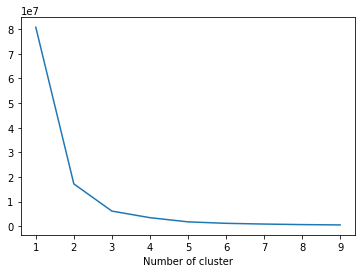

In [851]:
# criteria - Sum of squared distances of samples to their closest cluster center.
sse={}
fs_recency = fs_cust[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(fs_recency)
    fs_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [852]:
#optimum number is 3
n_clusters=3

In [853]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Recency']])
fs_cust['RecencyCluster'] = kmeans.predict(fs_cust[['Recency']])
fs_cust

CustId  Recency  RecencyCluster
0     cust_id_535      350               0
1     cust_id_876        7               0
2     cust_id_879        0               0
3    cust_id_4279        0               0
4    cust_id_1584        1               0
..            ...      ...             ...
225  cust_id_3846     1649               1
226  cust_id_3692      907               2
227   cust_id_455      168               0
228  cust_id_1301      872               2
229  cust_id_3728     1589               1

[230 rows x 3 columns]

In [854]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

fs_cust = order_cluster('RecencyCluster', 'Recency',fs_cust,False)
fs_cust

CustId  Recency  RecencyCluster
0     cust_id_535      350               2
1     cust_id_876        7               2
2     cust_id_879        0               2
3    cust_id_4279        0               2
4    cust_id_1584        1               2
..            ...      ...             ...
225  cust_id_2168     1708               0
226  cust_id_2089     1693               0
227  cust_id_1881     1688               0
228  cust_id_3846     1649               0
229  cust_id_3728     1589               0

[230 rows x 3 columns]

In [855]:
fs_cust.groupby('RecencyCluster')['Recency'].describe()

count         mean         std     min     25%     50%  \
RecencyCluster                                                           
0                33.0  1644.606061  195.923604  1275.0  1484.0  1677.0   
1                57.0   884.754386  207.634920   509.0   721.0   841.0   
2               140.0    94.842857  134.042100     0.0     1.0    26.5   

                   75%     max  
RecencyCluster                  
0               1798.0  1938.0  
1               1096.0  1236.0  
2                118.0   476.0

In [856]:
# next adding Frequency

In [857]:
# Frequency clustering

#get order counts for each user and create a dataframe with it
fs_frequency = sales.groupby('CustId').Date.count().reset_index()
fs_frequency.columns = ['CustId','Frequency']

#add this data to our main dataframe
fs_cust = pd.merge(fs_cust, fs_frequency, on='CustId')
fs_cust.head(5)

CustId  Recency  RecencyCluster  Frequency
0   cust_id_535      350               2      13306
1   cust_id_876        7               2     217841
2   cust_id_879        0               2      65277
3  cust_id_4279        0               2     186756
4  cust_id_1584        1               2      49178

In [858]:
#k-means
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Frequency']])
fs_cust['FrequencyCluster'] = kmeans.predict(fs_cust[['Frequency']])

#order the frequency cluster
fs_cust = order_cluster('FrequencyCluster', 'Frequency',fs_cust,True)

#see details of each cluster
fs_cust.groupby('FrequencyCluster')['Frequency'].describe()

count           mean           std       min        25%  \
FrequencyCluster                                                            
0                 207.0    1862.173913   4384.259290       1.0       6.00   
1                  21.0   48937.047619  17204.744440   26927.0   37424.00   
2                   2.0  202298.500000  21980.414293  186756.0  194527.25   

                       50%        75%       max  
FrequencyCluster                                 
0                     81.0     873.00   24619.0  
1                  45426.0   57032.00  101065.0  
2                 202298.5  210069.75  217841.0

In [859]:
#dropping customer, think outliers
# sales.drop(sales.loc[sales['CustId']=='cust_id_576'].index, inplace=True)
# sales.drop(sales.loc[sales['CustId']=='cust_id_1653'].index, inplace=True)
# sales.shape

In [860]:
fs_cust_sort=fs_cust.sort_values(by=['Frequency'], ascending =[False])
fs_cust_sort.head
len(fs_cust_sort)
fs_cust_sort.head(30)

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster
207   cust_id_876        7               2     217841                 2
208  cust_id_4279        0               2     186756                 2
223  cust_id_4201        0               2     101065                 1
225  cust_id_3163        0               2      73934                 1
209   cust_id_879        0               2      65277                 1
227  cust_id_2630        0               2      63204                 1
224  cust_id_2462        1               2      60147                 1
219  cust_id_4061        0               2      57032                 1
229  cust_id_1422        1               2      51176                 1
216  cust_id_1700       15               2      49933                 1
210  cust_id_1584        1               2      49178                 1
214  cust_id_3408        0               2      48639                 1
211  cust_id_2000        1               2      45426                 1
222  cust_id_2582        0               2      43587                 1
213  cust_id_1130        0               2      42008                 1
228   cust_id_178        5               2      41092                 1
217   cust_id_549        0               2      39251                 1
226  cust_id_1586        0               2      37424                 1
218  cust_id_1621      145               2      37162                 1
215  cust_id_1845       43               2      33730                 1
212  cust_id_2053       76               2      33636                 1
220   cust_id_832        0               2      27850                 1
221  cust_id_1610        0               2      26927                 1
1    cust_id_2768        1               2      24619                 0
43    cust_id_817       22               2      21438                 0
4     cust_id_325        1               2      19999                 0
17   cust_id_1604        0               2      19047                 0
12   cust_id_3518        0               2      18634                 0
6    cust_id_2439        0               2      16863                 0
15    cust_id_470        0               2      14024                 0

In [611]:
# one customer has 211573 orders, that drives the cluster to 1 data point.
# lets try to delete it cust_id_576

In [614]:
fs_cust_test=fs_cust
fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_3827'].index, inplace=True)
fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_1697'].index, inplace=True)
fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_2585'].index, inplace=True)


#fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_576'].index, inplace=True)
fs_cust_test

#k-means
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust_test[['Frequency']])
fs_cust_test['FrequencyCluster'] = kmeans.predict(fs_cust_test[['Frequency']])

#order the frequency cluster
fs_cust_test = order_cluster('FrequencyCluster', 'Frequency',fs_cust_test,True)

#see details of each cluster
fs_cust_test.groupby('FrequencyCluster')['Frequency'].describe()

count          mean          std      min      25%      50%  \
FrequencyCluster                                                                
0                 107.0    783.728972  1652.305460      1.0      4.0     50.0   
1                   9.0  20534.666667  4593.861502  15443.0  17474.0  18525.0   
2                   4.0  38256.500000  5316.107442  33681.0  34966.5  36814.0   

                      75%      max  
FrequencyCluster                    
0                   510.5   8619.0  
1                 23508.0  28458.0  
2                 40104.0  45717.0

In [615]:
# looks better w/o cust_id_576 
# Ill proceed w/o it
fs_cust=fs_cust_test

In [861]:
# Revenue Clustering

#calculate revenue for each customer
fs_revenue = sales.groupby('CustId').Revenue.sum().reset_index()

#merge it with our main dataframe
fs_cust = pd.merge(fs_cust, fs_revenue, on='CustId')
fs_cust.head(5)

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0   cust_id_535      350               2      13306                 0   
1  cust_id_2768        1               2      24619                 0   
2  cust_id_2110        4               2      12055                 0   
3  cust_id_1848        5               2       4218                 0   
4   cust_id_325        1               2      19999                 0   

        Revenue  
0  9.649215e+06  
1  2.446567e+07  
2  1.163927e+07  
3  5.774035e+06  
4  1.700047e+07

In [862]:
#apply clustering
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Revenue']])
fs_cust['RevenueCluster'] = kmeans.predict(fs_cust[['Revenue']])


#order the cluster numbers
fs_cust = order_cluster('RevenueCluster', 'Revenue',fs_cust,True)
fs_cust
#show details of the dataframe
fs_cust.groupby('RevenueCluster')['Revenue'].describe()

count          mean           std           min           25%  \
RevenueCluster                                                                  
0               202.0  1.245609e+06  2.674273e+06  9.333310e+00  5.952985e+03   
1                18.0  2.643962e+07  8.644786e+06  1.437129e+07  1.950807e+07   
2                10.0  7.477528e+07  1.833906e+07  5.371216e+07  6.095605e+07   

                         50%           75%           max  
RevenueCluster                                            
0               7.593714e+04  6.664313e+05  1.163927e+07  
1               2.500771e+07  3.035037e+07  4.121114e+07  
2               7.344263e+07  8.324482e+07  1.161112e+08

In [863]:
#calculate overall score and use mean() to see details

fs_cust['OverallScore'] = fs_cust['RecencyCluster'] + fs_cust['FrequencyCluster'] + fs_cust['RevenueCluster']
fs_cust.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

Recency      Frequency       Revenue
OverallScore                                          
0             1644.606061     105.151515  1.139152e+05
1              884.754386     201.526316  2.854402e+05
2              115.357143    2575.401786  2.067713e+06
3               12.600000   16413.600000  2.669587e+07
4               10.846154   40986.461538  2.634107e+07
5               18.375000   61856.750000  7.208512e+07
6                3.500000  202298.500000  8.553593e+07

In [864]:
# Let's create a clustering based on score 

fs_cust['Segment'] = 'Low-Value'
fs_cust.loc[fs_cust['OverallScore']>2,'Segment'] = 'Mid-Value' 
fs_cust.loc[fs_cust['OverallScore']>4,'Segment'] = 'High-Value' 


In [865]:
fs_cust.head(10)

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0   cust_id_535      350               2      13306                 0   
1  cust_id_2110        4               2      12055                 0   
2  cust_id_1848        5               2       4218                 0   
3   cust_id_276        1               2       6223                 0   
4  cust_id_1066       13               2        209                 0   
5  cust_id_2935        1               2      10147                 0   
6   cust_id_228        1               2      13547                 0   
7  cust_id_2600       21               2        349                 0   
8  cust_id_1103        1               2       1381                 0   
9  cust_id_3518        0               2      18634                 0   

        Revenue  RevenueCluster  OverallScore    Segment  
0  9.649215e+06               0             2  Low-Value  
1  1.163927e+07               0             2  Low-Value  
2  5.774035e+06               0             2  Low-Value  
3  5.908336e+06               0             2  Low-Value  
4  2.616767e+05               0             2  Low-Value  
5  6.140135e+06               0             2  Low-Value  
6  1.065022e+07               0             2  Low-Value  
7  1.851955e+05               0             2  Low-Value  
8  1.345255e+06               0             2  Low-Value  
9  7.568616e+06               0             2  Low-Value

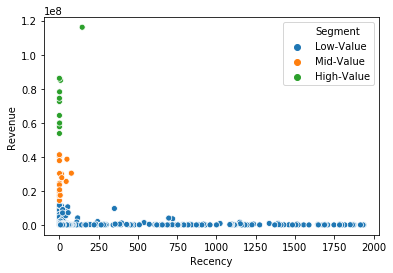

In [866]:
sns.scatterplot(x="Recency", y="Revenue", data=fs_cust, hue="Segment")

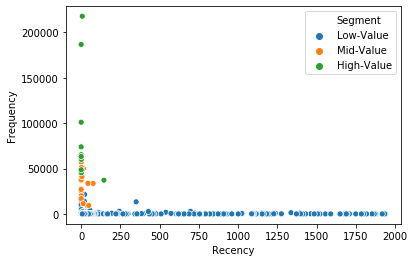

In [867]:
sns.scatterplot(x="Recency", y="Frequency", data=fs_cust, hue="Segment")

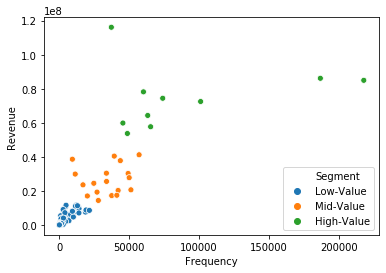

In [868]:
sns.scatterplot(x="Frequency", y="Revenue", data=fs_cust, hue="Segment")

# High Value: Improve Retention
# Mid Value: Improve Retention + Increase Frequency
# Low Value: Increase Frequency


In marketing, customer lifetime value (CLV or often CLTV), lifetime customer value (LCV), or life-time value (LTV) is a prediction of the net profit attributed to the entire future relationship with a customer.


In [869]:
# model build on 2014-2017
# predict 2017-2019

fs_calc = sales[(sales.Date >= date(2014,1,1)) & (sales.Date < date(2017,1,1))].reset_index(drop=True)
fs_next = sales[(sales.Date >= date(2017,1,1)) & (sales.Date < date(2019,12,31))].reset_index(drop=True)

In [870]:
#create fs_calc for assigning clustering
# same action as above just for training data set

fs_cust = pd.DataFrame(fs_calc['CustId'].unique())
fs_cust.columns = ['CustId']

#calculate recency score
fs_max_purchase = fs_calc.groupby('CustId').Date.max().reset_index()
fs_max_purchase.columns = ['CustId','MaxPurchaseDate']
fs_max_purchase['Recency'] = (fs_max_purchase['MaxPurchaseDate'].max() - fs_max_purchase['MaxPurchaseDate']).dt.days
fs_cust = pd.merge(fs_cust, fs_max_purchase[['CustId','Recency']], on='CustId')

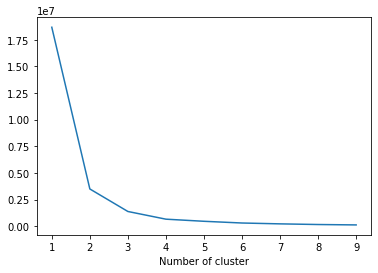

In [871]:
# criteria - Sum of squared distances of samples to their closest cluster center.
sse={}
fs_recency = fs_cust[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(fs_recency)
    fs_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [872]:
n_clusters=3

In [873]:
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Recency']])
fs_cust['RecencyCluster'] = kmeans.predict(fs_cust[['Recency']])

fs_cust = order_cluster('RecencyCluster', 'Recency',fs_cust,False)
fs_cust['RecencyCluster'].value_counts()
fs_cust.groupby('RecencyCluster')['Recency'].describe()

count        mean         std    min    25%    50%    75%  \
RecencyCluster                                                              
0                35.0  845.114286  149.025614  603.0  710.5  830.0  976.5   
1                39.0  349.128205  109.823586  192.0  258.0  323.0  413.0   
2                96.0   31.375000   42.111194    0.0    2.0   12.5   49.0   

                   max  
RecencyCluster          
0               1080.0  
1                571.0  
2                165.0

In [874]:
#calcuate frequency score
fs_frequency = fs_calc.groupby('CustId').Date.count().reset_index()
fs_frequency.columns = ['CustId','Frequency']
fs_cust = pd.merge(fs_cust, fs_frequency, on='CustId')

In [875]:
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Frequency']])
fs_cust['FrequencyCluster'] = kmeans.predict(fs_cust[['Frequency']])

fs_cust = order_cluster('FrequencyCluster', 'Frequency',fs_cust,True)
fs_cust['FrequencyCluster'].value_counts()

0    144
1     23
2      3
Name: FrequencyCluster, dtype: int64

In [876]:
fs_cust_sort=fs_cust.sort_values(by=['Frequency'], ascending =[False])
fs_cust_sort.head(20)

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster
144   cust_id_876        3               2     120471                 2
145  cust_id_4279        3               2     108393                 2
146  cust_id_4201        9               2      66887                 2
155  cust_id_1700        1               2      43016                 1
163  cust_id_3163        0               2      39220                 1
168  cust_id_1422       18               2      38401                 1
147   cust_id_879        1               2      34794                 1
158  cust_id_4061        2               2      33713                 1
157  cust_id_1621        0               2      33038                 1
150  cust_id_2000        9               2      30319                 1
148  cust_id_1584        2               2      29907                 1
167   cust_id_178       11               2      29775                 1
154  cust_id_1845        0               2      29544                 1
161  cust_id_2582        1               2      28582                 1
166  cust_id_2630        7               2      26052                 1
153  cust_id_3408        2               2      24882                 1
152  cust_id_1130        1               2      21849                 1
162  cust_id_2462       17               2      21846                 1
156   cust_id_549        1               2      20128                 1
151  cust_id_2053        1               2      19786                 1

In [877]:
fs_cust_test=fs_cust
#fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_576'].index, inplace=True)

# fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_876'].index, inplace=True)
# fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_4279'].index, inplace=True)
#fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_2585'].index, inplace=True)

In [878]:
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust_test[['Frequency']])
fs_cust_test['FrequencyCluster'] = kmeans.predict(fs_cust_test[['Frequency']])

fs_cust_test = order_cluster('FrequencyCluster', 'Frequency',fs_cust_test,True)
fs_cust_test['FrequencyCluster'].value_counts()

0    141
1     15
2     12
Name: FrequencyCluster, dtype: int64

In [879]:
# lets use without 576
#fs_cust=fs_cust_test

#calcuate revenue score
fs_calc['Revenue'] = fs_calc['SellPrice'] * fs_calc['Quantity']
fs_revenue = fs_calc.groupby('CustId').Revenue.sum().reset_index()
fs_cust = pd.merge(fs_cust, fs_revenue, on='CustId')
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Revenue']])
fs_cust['RevenueCluster'] = kmeans.predict(fs_cust[['Revenue']])
fs_cust = order_cluster('RevenueCluster', 'Revenue',fs_cust,True)
fs_cust

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0     cust_id_535        0               2      10654                 2   
1    cust_id_2110        1               2       7318                 0   
2    cust_id_1848       50               2       2288                 0   
3     cust_id_325        2               2      10415                 2   
4     cust_id_276        8               2       3761                 0   
..            ...      ...             ...        ...               ...   
163  cust_id_2462       17               2      21846                 2   
164  cust_id_3163        0               2      39220                 1   
165  cust_id_2630        7               2      26052                 2   
166  cust_id_1422       18               2      38401                 1   
167  cust_id_1621        0               2      33038                 1   

          Revenue  RevenueCluster  
0    7.579433e+06               0  
1    6.488310e+06               0  
2    2.013588e+06               0  
3    1.086783e+07               0  
4    3.832066e+06               0  
..            ...             ...  
163  1.891067e+07               1  
164  3.028976e+07               1  
165  2.573306e+07               1  
166  1.494912e+07               1  
167  1.094220e+08               2  

[168 rows x 7 columns]

In [880]:
fs_cust_test.groupby('FrequencyCluster')['Frequency'].describe()

count          mean           std      min      25%  \
FrequencyCluster                                                        
0                 141.0    691.751773   1599.434999      1.0      5.0   
1                  15.0  17349.133333   5120.205393   9452.0  14650.5   
2                  12.0  36433.000000  10606.294452  28582.0  29874.0   

                      50%       75%      max  
FrequencyCluster                              
0                    52.0    465.00   8495.0  
1                 16317.0  20987.00  26052.0  
2                 33375.5  38605.75  66887.0

In [881]:
#overall scoring
fs_cust['OverallScore'] = fs_cust['RecencyCluster'] + fs_cust['FrequencyCluster'] + fs_cust['RevenueCluster']
fs_cust['Segment'] = 'Low-Value'
fs_cust.loc[fs_cust['OverallScore']>1,'Segment'] = 'Mid-Value' 
fs_cust.loc[fs_cust['OverallScore']>3,'Segment'] = 'High-Value' 

In [882]:
fs_cust['OverallScore'].value_counts()

2    67
1    39
0    35
4    19
5     7
3     1
Name: OverallScore, dtype: int64

In [883]:
#calculate revenue and create a new dataframe for it from modeling years 2017-2019
fs_next['Revenue'] = fs_next['SellPrice'] * fs_next['Quantity']
fs_cust_next = fs_next.groupby('CustId')['Revenue'].sum().reset_index()
fs_cust_next.columns = ['CustId','next_Revenue']
fs_cust_next.head(5)

CustId  next_Revenue
0  cust_id_1028  3.177632e+06
1  cust_id_1031  2.207994e+03
2  cust_id_1051  3.683231e+05
3  cust_id_1066  2.935993e+04
4  cust_id_1103  1.345255e+06

In [884]:
fs_merge = pd.merge(fs_cust, fs_cust_next, on='CustId', how='left')
fs_merge = fs_merge.fillna(0)
fs_merge.head(10)

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0   cust_id_535        0               2      10654                 2   
1  cust_id_2110        1               2       7318                 0   
2  cust_id_1848       50               2       2288                 0   
3   cust_id_325        2               2      10415                 2   
4   cust_id_276        8               2       3761                 0   
5  cust_id_2439        0               2       9452                 2   
6  cust_id_3603       49               2       1090                 0   
7  cust_id_2935       21               2       8360                 0   
8   cust_id_228        2               2       3902                 0   
9  cust_id_2600        0               2        154                 0   

        Revenue  RevenueCluster  OverallScore     Segment  next_Revenue  
0  7.579433e+06               0             4  High-Value  2.069781e+06  
1  6.488310e+06               0             2   Mid-Value  5.150964e+06  
2  2.013588e+06               0             2   Mid-Value  3.760447e+06  
3  1.086783e+07               0             4  High-Value  6.132642e+06  
4  3.832066e+06               0             2   Mid-Value  2.076269e+06  
5  1.147869e+07               0             4  High-Value  1.206784e+07  
6  3.342220e+06               0             2   Mid-Value  2.498087e+05  
7  5.043094e+06               0             2   Mid-Value  1.097041e+06  
8  3.206619e+06               0             2   Mid-Value  7.443600e+06  
9  6.985316e+04               0             2   Mid-Value  1.153424e+05

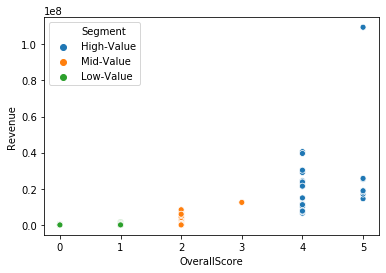

In [885]:
sns.scatterplot(x="OverallScore", y="Revenue", data=fs_merge, hue="Segment")

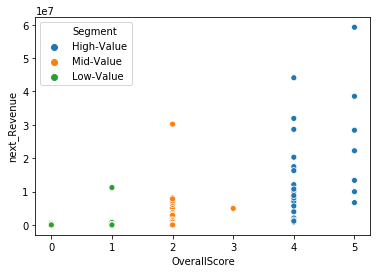

In [886]:
sns.scatterplot(x="OverallScore", y="next_Revenue", data=fs_merge, hue="Segment")

In [887]:
#remove outliers
fs_merge = fs_merge[fs_merge['next_Revenue']<fs_merge['next_Revenue'].quantile(0.9)]
# drop next revenue equal to 0
fs_merge.drop(fs_merge.loc[fs_merge['next_Revenue']==0].index, inplace=True)

#creating 3 clusters of next revenue
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(fs_merge[['next_Revenue']])
fs_merge['LTVCluster'] = kmeans.predict(fs_merge[['next_Revenue']])

#order cluster number based on LTV
fs_merge = order_cluster('LTVCluster', 'next_Revenue',fs_merge,True)

#creatinga new cluster dataframe
fs_cluster = fs_merge.copy()

#see details of the clusters
fs_cluster.groupby('LTVCluster')['next_Revenue'].describe()

count          mean           std           min           25%  \
LTVCluster                                                                  
0            65.0  2.097156e+05  3.446562e+05  6.266651e+01  4.959988e+03   
1            13.0  2.467324e+06  9.139242e+05  1.469587e+06  1.626096e+06   
2            14.0  6.848523e+06  1.151962e+06  4.954500e+06  6.128450e+06   

                     50%           75%           max  
LTVCluster                                            
0           3.331725e+04  2.135141e+05  1.247434e+06  
1           2.081133e+06  3.177632e+06  3.977566e+06  
2           6.878000e+06  7.704558e+06  8.811227e+06

In [888]:
fs_cluster.head(10)

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0   cust_id_535        0               2      10654                 2   
1  cust_id_1848       50               2       2288                 0   
2   cust_id_276        8               2       3761                 0   
3  cust_id_2280        1               2       1326                 0   
4  cust_id_1203       16               2       5312                 0   
5  cust_id_2071       49               2        664                 0   
6   cust_id_959       10               2       4036                 0   
7  cust_id_1028       15               2       5391                 0   
8  cust_id_2881       18               2        346                 0   
9  cust_id_3932        9               2        465                 0   

        Revenue  RevenueCluster  OverallScore     Segment  next_Revenue  \
0  7.579433e+06               0             4  High-Value  2.069781e+06   
1  2.013588e+06               0             2   Mid-Value  3.760447e+06   
2  3.832066e+06               0             2   Mid-Value  2.076269e+06   
3  1.404576e+06               0             2   Mid-Value  2.172423e+06   
4  3.674053e+06               0             2   Mid-Value  1.626096e+06   
5  4.064790e+05               0             2   Mid-Value  2.081133e+06   
6  2.560426e+06               0             2   Mid-Value  3.671461e+06   
7  1.479902e+06               0             2   Mid-Value  3.177632e+06   
8  8.284606e+05               0             2   Mid-Value  1.562395e+06   
9  2.491392e+06               0             2   Mid-Value  2.893213e+06   

   LTVCluster  
0           1  
1           1  
2           1  
3           1  
4           1  
5           1  
6           1  
7           1  
8           1  
9           1

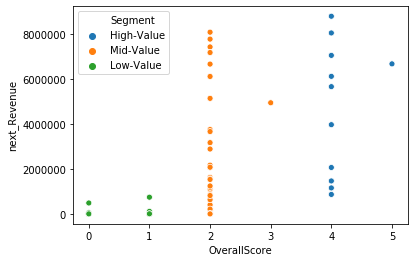

In [889]:
sns.scatterplot(x="OverallScore", y="next_Revenue", data=fs_cluster, hue="Segment")

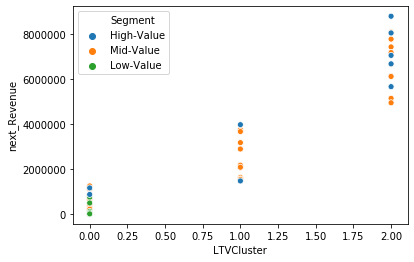

In [890]:
sns.scatterplot(x="LTVCluster", y="next_Revenue", data=fs_cluster, hue="Segment")

In [891]:
#convert categorical columns to numerical
fs_class = pd.get_dummies(fs_cluster)
fs_class_matrix=fs_cluster

#calculate and show correlations
corr_matrix = fs_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster             1.000000
next_Revenue           0.957420
OverallScore           0.529269
Frequency              0.523386
FrequencyCluster       0.463259
                         ...   
CustId_cust_id_3647   -0.062914
CustId_cust_id_2935   -0.062914
CustId_cust_id_3603   -0.062914
Segment_Low-Value     -0.346501
Recency               -0.349924
Name: LTVCluster, Length: 104, dtype: float64

In [892]:
#create X and y, X will be feature set and y is the label - LTV
X = fs_class.drop(['LTVCluster','next_Revenue'],axis=1)
y = fs_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [893]:
# XGBoost Multiclassification Model

ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.47
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.00      0.00      0.00         4
           2       0.20      0.33      0.25         3

    accuracy                           0.47        19
   macro avg       0.31      0.33      0.32        19
weighted avg       0.49      0.47      0.48        19



In [894]:
# Random Forrest Multiclassification Model

ltv_rf_model = RandomForestClassifier(n_estimators = 1000,criterion = 'entropy', random_state = 42).fit(X_train, y_train)

print('Accuracy of RF classifier on training set: {:.2f}'
       .format(ltv_rf_model.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
       .format(ltv_rf_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.74
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       1.00      0.25      0.40         4
           2       0.43      1.00      0.60         3

    accuracy                           0.74        19
   macro avg       0.78      0.69      0.62        19
weighted avg       0.85      0.74      0.73        19



In [895]:
#Predict next purchase

In [896]:
fs_prev = sales[(sales.Date >= date(2014,1,1)) & (sales.Date < date(2017,1,1))].reset_index(drop=True)
fs_next = sales[(sales.Date >= date(2017,1,1)) & (sales.Date < date(2019,12,31))].reset_index(drop=True)
fs_user = pd.DataFrame(fs_prev['CustId'].unique())
fs_user.columns = ['CustId']
fs_user.head(10)

CustId
0   cust_id_535
1   cust_id_876
2   cust_id_879
3  cust_id_4279
4  cust_id_1584
5  cust_id_2768
6  cust_id_2000
7  cust_id_2110
8  cust_id_2053
9  cust_id_1130

In [897]:
#create a dataframe with customer id and first purchase date in fs_next
fs_next_first_purchase = fs_next.groupby('CustId').Date.min().reset_index()
fs_next_first_purchase.columns = ['CustId','MinPurchaseDate']

#create a dataframe with customer id and last purchase date in fs_next
fs_last_purchase = fs_prev.groupby('CustId').Date.max().reset_index()
fs_last_purchase.columns = ['CustId','MaxPurchaseDate']

#merge two dataframes
fs_purchase_dates = pd.merge(fs_last_purchase,fs_next_first_purchase,on='CustId',how='left')

#calculate the time difference in days:
fs_purchase_dates['NextPurchaseDay'] = (fs_purchase_dates['MinPurchaseDate'] - fs_purchase_dates['MaxPurchaseDate']).dt.days

#merge with fs_user 
fs_user = pd.merge(fs_user, fs_purchase_dates[['CustId','NextPurchaseDay']],on='CustId',how='left')

#print fs_user
fs_user.head()

#fill NA values with 999, meaning only one purchase in prev dataset
fs_user = fs_user.fillna(999)
fs_user.head(10)
len(fs_user)

170

In [898]:
#create a dataframe with CustomerID and Invoice Date
fs_day_order = fs_prev[['CustId','Date']]
#convert Invoice Datetime to day
fs_day_order['InvoiceDay'] = fs_prev['Date'].dt.date
fs_day_order = fs_day_order.sort_values(['CustId','Date'])
len(fs_day_order)

1023834

In [899]:
#drop duplicates
fs_day_order = fs_day_order.drop_duplicates(subset=['CustId','InvoiceDay'],keep='first')
fs_day_order.head(10)
len(fs_day_order)

13694

In [900]:
#shifting last 3 purchase dates
fs_day_order['PrevInvoiceDate'] = fs_day_order.groupby('CustId')['InvoiceDay'].shift(1)
fs_day_order['T2InvoiceDate'] = fs_day_order.groupby('CustId')['InvoiceDay'].shift(2)
fs_day_order['T3InvoiceDate'] = fs_day_order.groupby('CustId')['InvoiceDay'].shift(3)

In [901]:
# find differences between purchases
fs_day_order['DayDiff'] = (fs_day_order['InvoiceDay'] - fs_day_order['PrevInvoiceDate']).dt.days
fs_day_order['DayDiff2'] = (fs_day_order['InvoiceDay'] - fs_day_order['T2InvoiceDate']).dt.days
fs_day_order['DayDiff3'] = (fs_day_order['InvoiceDay'] - fs_day_order['T3InvoiceDate']).dt.days

In [902]:
# find mean and std
fs_day_diff = fs_day_order.groupby('CustId').agg({'DayDiff': ['mean','std']}).reset_index()
fs_day_diff.columns = ['CustId', 'DayDiffMean','DayDiffStd']
fs_day_diff
len(fs_day_diff)

170

In [903]:
fs_day_order_last = fs_day_order.drop_duplicates(subset=['CustId'],keep='last')
fs_day_order_last = fs_day_order_last.dropna()
fs_day_order_last.head(10)

CustId       Date  InvoiceDay PrevInvoiceDate T2InvoiceDate  \
873026   cust_id_1028 2016-12-15  2016-12-15      2016-11-29    2016-10-14   
523251   cust_id_1066 2016-06-06  2016-06-06      2016-04-19    2016-04-04   
399686   cust_id_1130 2016-12-29  2016-12-29      2016-12-21    2016-12-16   
854555   cust_id_1203 2016-12-14  2016-12-14      2016-12-01    2016-11-23   
1018350  cust_id_1276 2016-04-07  2016-04-07      2016-02-02    2015-10-28   
969972   cust_id_1422 2016-12-12  2016-12-12      2016-12-08    2016-12-06   
1007961  cust_id_1508 2016-11-17  2016-11-17      2016-07-11    2016-07-01   
1013639   cust_id_153 2016-11-30  2016-11-30      2016-10-27    2016-10-06   
304191   cust_id_1584 2016-12-28  2016-12-28      2016-12-27    2016-12-23   
833798   cust_id_1586 2016-12-30  2016-12-30      2016-12-15    2016-12-14   

        T3InvoiceDate  DayDiff  DayDiff2  DayDiff3  
873026     2016-10-10     16.0      62.0      66.0  
523251     2016-02-27     48.0      63.0     100.0  
399686     2016-12-08      8.0      13.0      21.0  
854555     2016-11-21     13.0      21.0      23.0  
1018350    2015-05-06     65.0     162.0     337.0  
969972     2016-12-03      4.0       6.0       9.0  
1007961    2016-04-25    129.0     139.0     206.0  
1013639    2016-09-02     34.0      55.0      89.0  
304191     2016-12-22      1.0       5.0       6.0  
833798     2016-12-08     15.0      16.0      22.0

In [904]:
fs_day_order_last = pd.merge(fs_day_order_last, fs_day_diff, on='CustId')
fs_day_order_last.head(10)

CustId       Date  InvoiceDay PrevInvoiceDate T2InvoiceDate  \
0  cust_id_1028 2016-12-15  2016-12-15      2016-11-29    2016-10-14   
1  cust_id_1066 2016-06-06  2016-06-06      2016-04-19    2016-04-04   
2  cust_id_1130 2016-12-29  2016-12-29      2016-12-21    2016-12-16   
3  cust_id_1203 2016-12-14  2016-12-14      2016-12-01    2016-11-23   
4  cust_id_1276 2016-04-07  2016-04-07      2016-02-02    2015-10-28   
5  cust_id_1422 2016-12-12  2016-12-12      2016-12-08    2016-12-06   
6  cust_id_1508 2016-11-17  2016-11-17      2016-07-11    2016-07-01   
7   cust_id_153 2016-11-30  2016-11-30      2016-10-27    2016-10-06   
8  cust_id_1584 2016-12-28  2016-12-28      2016-12-27    2016-12-23   
9  cust_id_1586 2016-12-30  2016-12-30      2016-12-15    2016-12-14   

  T3InvoiceDate  DayDiff  DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  
0    2016-10-10     16.0      62.0      66.0    13.278481   11.528045  
1    2016-02-27     48.0      63.0     100.0    24.611111   29.733365  
2    2016-12-08      8.0      13.0      21.0     3.886121    3.116979  
3    2016-11-21     13.0      21.0      23.0    11.393617   11.080563  
4    2015-05-06     65.0     162.0     337.0   112.333333   56.580326  
5    2016-12-03      4.0       6.0       9.0     4.819820    3.619200  
6    2016-04-25    129.0     139.0     206.0    28.861111   49.053995  
7    2016-09-02     34.0      55.0      89.0    36.481481   30.113082  
8    2016-12-22      1.0       5.0       6.0     2.549065    1.743485  
9    2016-12-08     15.0      16.0      22.0     5.717277    7.605653

In [905]:
fs_cust = pd.merge(fs_user, fs_cust, on='CustId')
fs_cust.head(10)

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0   cust_id_535              6.0        0               2      10654   
1   cust_id_879              6.0        1               2      34794   
2  cust_id_1584              6.0        2               2      29907   
3  cust_id_2768              6.0        0               2      16317   
4  cust_id_2000             13.0        9               2      30319   
5  cust_id_2110             15.0        1               2       7318   
6  cust_id_2053              5.0        1               2      19786   
7  cust_id_1130              8.0        1               2      21849   
8  cust_id_1848             77.0       50               2       2288   
9  cust_id_3408              7.0        2               2      24882   

   FrequencyCluster       Revenue  RevenueCluster  OverallScore     Segment  
0                 2  7.579433e+06               0             4  High-Value  
1                 1  2.902659e+07               1             4  High-Value  
2                 1  2.141297e+07               1             4  High-Value  
3                 2  1.450973e+07               1             5  High-Value  
4                 1  3.955657e+07               1             4  High-Value  
5                 0  6.488310e+06               0             2   Mid-Value  
6                 2  1.703963e+07               1             5  High-Value  
7                 2  1.015234e+07               0             4  High-Value  
8                 0  2.013588e+06               0             2   Mid-Value  
9                 2  2.532549e+07               1             5  High-Value

In [906]:
fs_user2 = pd.merge(fs_cust, fs_day_order_last[['CustId','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustId')
#create fs_class as a copy of fs_user before applying get_dummies
fs_user2.head(10)

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0   cust_id_535              6.0        0               2      10654   
1   cust_id_879              6.0        1               2      34794   
2  cust_id_1584              6.0        2               2      29907   
3  cust_id_2768              6.0        0               2      16317   
4  cust_id_2000             13.0        9               2      30319   
5  cust_id_2110             15.0        1               2       7318   
6  cust_id_2053              5.0        1               2      19786   
7  cust_id_1130              8.0        1               2      21849   
8  cust_id_1848             77.0       50               2       2288   
9  cust_id_3408              7.0        2               2      24882   

   FrequencyCluster       Revenue  RevenueCluster  OverallScore     Segment  \
0                 2  7.579433e+06               0             4  High-Value   
1                 1  2.902659e+07               1             4  High-Value   
2                 1  2.141297e+07               1             4  High-Value   
3                 2  1.450973e+07               1             5  High-Value   
4                 1  3.955657e+07               1             4  High-Value   
5                 0  6.488310e+06               0             2   Mid-Value   
6                 2  1.703963e+07               1             5  High-Value   
7                 2  1.015234e+07               0             4  High-Value   
8                 0  2.013588e+06               0             2   Mid-Value   
9                 2  2.532549e+07               1             5  High-Value   

   DayDiff  DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  
0      2.0       8.0      11.0     5.844920    5.899017  
1      2.0       7.0       8.0     2.723192    2.130888  
2      1.0       5.0       6.0     2.549065    1.743485  
3      1.0       2.0       9.0     2.547786    1.982559  
4      5.0       7.0      12.0     4.839286    3.287573  
5     14.0      15.0      20.0     2.858639    2.287916  
6      1.0       6.0       7.0     1.841484    1.291278  
7      8.0      13.0      21.0     3.886121    3.116979  
8     35.0      63.0      70.0    14.486111   18.104542  
9      6.0       7.0       8.0     2.035448    1.506575

In [907]:
fs_class = fs_user2.copy()
fs_class = pd.get_dummies(fs_class)
fs_class.head(10)

NextPurchaseDay  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0              6.0        0               2      10654                 2   
1              6.0        1               2      34794                 1   
2              6.0        2               2      29907                 1   
3              6.0        0               2      16317                 2   
4             13.0        9               2      30319                 1   
5             15.0        1               2       7318                 0   
6              5.0        1               2      19786                 2   
7              8.0        1               2      21849                 2   
8             77.0       50               2       2288                 0   
9              7.0        2               2      24882                 2   

        Revenue  RevenueCluster  OverallScore  DayDiff  DayDiff2  ...  \
0  7.579433e+06               0             4      2.0       8.0  ...   
1  2.902659e+07               1             4      2.0       7.0  ...   
2  2.141297e+07               1             4      1.0       5.0  ...   
3  1.450973e+07               1             5      1.0       2.0  ...   
4  3.955657e+07               1             4      5.0       7.0  ...   
5  6.488310e+06               0             2     14.0      15.0  ...   
6  1.703963e+07               1             5      1.0       6.0  ...   
7  1.015234e+07               0             4      8.0      13.0  ...   
8  2.013588e+06               0             2     35.0      63.0  ...   
9  2.532549e+07               1             5      6.0       7.0  ...   

   CustId_cust_id_646  CustId_cust_id_817  CustId_cust_id_832  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   
5                   0                   0                   0   
6                   0                   0                   0   
7                   0                   0                   0   
8                   0                   0                   0   
9                   0                   0                   0   

   CustId_cust_id_879  CustId_cust_id_935  CustId_cust_id_959  \
0                   0                   0                   0   
1                   1                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   
5                   0                   0                   0   
6                   0                   0                   0   
7                   0                   0                   0   
8                   0                   0                   0   
9                   0                   0                   0   

   CustId_cust_id_992  Segment_High-Value  Segment_Low-Value  \
0                   0                   1                  0   
1                   0                   1                  0   
2                   0                   1                  0   
3                   0                   1                  0   
4                   0                   1                  0   
5                   0                   0                  0   
6                   0                   1                  0   
7                   0                   1                  0   
8                   0                   0                  0   
9                   0                   1                  0   

   Segment_Mid-Value  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
5                  1  
6                  0  
7                  0  
8                 

In [908]:
fs_class=fs_class.sort_values(by=['NextPurchaseDay'], ascending =[False])
fs_class

NextPurchaseDay  Recency  RecencyCluster  Frequency  FrequencyCluster  \
81           1043.0      694               0         12                 0   
94            999.0      417               1        110                 0   
87            999.0       30               2          6                 0   
63            999.0      290               1        855                 0   
62            999.0      378               1        697                 0   
..              ...      ...             ...        ...               ...   
6               5.0        1               2      19786                 2   
32              5.0        0               2      13881                 2   
17              4.0        1               2      20128                 2   
24              4.0        0               2      15504                 2   
31              4.0        0               2      39220                 1   

         Revenue  RevenueCluster  OverallScore  DayDiff  DayDiff2  ...  \
81  6.549984e+04               0             0     37.0      51.0  ...   
94  2.854660e+04               0             1     62.0     126.0  ...   
87  3.063326e+04               0             2     37.0     547.0  ...   
63  1.557157e+06               0             1    245.0     363.0  ...   
62  5.101507e+05               0             1     45.0      77.0  ...   
..           ...             ...           ...      ...       ...  ...   
6   1.703963e+07               1             5      1.0       6.0  ...   
32  6.486532e+06               0             4     15.0      16.0  ...   
17  1.819181e+07               1             5      1.0       9.0  ...   
24  1.119850e+07               0             4      1.0       3.0  ...   
31  3.028976e+07               1             4      2.0       3.0  ...   

    CustId_cust_id_646  CustId_cust_id_817  CustId_cust_id_832  \
81                   0                   0                   0   
94                   0                   0                   0   
87                   0                   0                   0   
63                   0                   0                   0   
62                   0                   0                   0   
..                 ...                 ...                 ...   
6                    0                   0                   0   
32                   0                   0                   0   
17                   0                   0                   0   
24                   0                   0                   0   
31                   0                   0                   0   

    CustId_cust_id_879  CustId_cust_id_935  CustId_cust_id_959  \
81                   0                   0                   0   
94                   0                   0                   0   
87                   0                   0                   0   
63                   0                   0                   0   
62                   0                   0                   0   
..                 ...                 ...                 ...   
6                    0                   0                   0   
32                   0                   0                   0   
17                   0                   0                   0   
24                   0                   0                   0   
31                   0                   0                   0   

    CustId_cust_id_992  Segment_High-Value  Segment_Low-Value  \
81                   0                   0                  1   
94                   0                   0                  1   
87                   0                   0                  0   
63                   0                   0                  1   
62                   0                   0                  1   
..                 ...                 ...                ...   
6                    0                   1                  0   
32                   0                   1                  0   
17                 

In [909]:
fs_class['NextPurchaseDayRange'] = 2
fs_class.loc[fs_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 1
fs_class.loc[fs_class.NextPurchaseDay>200,'NextPurchaseDayRange'] = 0

In [910]:
fs_class.groupby('NextPurchaseDayRange')['NextPurchaseDay'].describe()

count        mean         std    min    25%    50%  \
NextPurchaseDayRange                                                       
0                      27.0  778.851852  332.701033  218.0  469.0  999.0   
1                      21.0   96.809524   34.152041   53.0   69.0   93.0   
2                      47.0   13.468085   10.008368    4.0    6.0   10.0   

                        75%     max  
NextPurchaseDayRange                 
0                     999.0  1043.0  
1                     124.0   179.0  
2                      18.0    48.0

In [911]:
#train & test split

#fs_class = fs_class.drop('NextPurchaseDay',axis=1)

X, y = fs_class.drop('NextPurchaseDayRange',axis=1), fs_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2, random_state=42)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.60526316 0.71052632]
NB [0.71052632 0.5       ]
RF [0.78947368 0.92105263]
SVC [0.39473684 0.68421053]
Dtree [1. 1.]
XGB [1. 1.]
KNN [0.65789474 0.47368421]


In [941]:
#converting the type of Invoice Date Field from string to datetime.
sales['Date'] = pd.to_datetime(sales['Date'])

cust_group = sales.groupby(['CustId','Date','PostalCode'])['SellPrice'].sum().reset_index()

In [942]:
list(sales.columns) 

['Date',
 'OrderNumber',
 'OrderLineNumber',
 'Quantity',
 'SellPrice',
 'CCN',
 'PartnerNumber',
 'Material',
 'ItemCategoryGroup',
 'ItemCategory',
 'ItemDescription',
 'ProductCode',
 'ProductDescription',
 'NounCodeDescription',
 'NounCode',
 'ShipFrom',
 'CustomerName',
 'CustId',
 'City',
 'State',
 'PostalCode',
 'Country',
 'Region',
 'SubRegion',
 'Industry',
 'IndustryGroup',
 'Plant',
 'PlantType',
 'PlantPlatform',
 'Market',
 'MonthYear',
 'Column 32',
 'InvoiceYearMonth',
 'Revenue',
 'MinPurchaseDate',
 'MinPurchaseYearMonth',
 'UserType']

In [943]:
frequency = cust_group.groupby('CustId').Date.count().reset_index()
frequency.columns = ['CustId','frequency']
max_purchase = cust_group.groupby('CustId').Date.max().reset_index()
min_purchase = cust_group.groupby('CustId').Date.min().reset_index()
max_purchase.columns = ['CustId','max_purchase']
min_purchase.columns = ['CustId','min_purchase']

In [944]:
fs = pd.merge(frequency,min_purchase,on='CustId',how='left')
fs = pd.merge(fs,max_purchase,on='CustId',how='left')
fs['Period'] = (fs['max_purchase'] - fs['min_purchase']).dt.days
fs

CustId  frequency min_purchase max_purchase  Period
0    cust_id_1028        149   2014-01-31   2019-05-07    1922
1    cust_id_1031          1   2018-07-20   2018-07-20       0
2    cust_id_1033          1   2016-01-29   2016-01-29       0
3    cust_id_1051         20   2017-06-21   2017-10-12     113
4    cust_id_1066         58   2014-01-02   2019-04-24    1938
..            ...        ...          ...          ...     ...
225   cust_id_935         15   2014-12-30   2019-04-25    1577
226   cust_id_958          1   2014-03-28   2014-03-28       0
227   cust_id_959        173   2014-01-08   2019-05-06    1944
228   cust_id_988          3   2016-09-27   2016-11-01      35
229   cust_id_992         14   2014-01-21   2016-02-13     753

[230 rows x 5 columns]

In [945]:
# remove one time purchaces
fs=fs.loc[fs['frequency'] > 1]

In [946]:
fs['rate'] = fs['frequency']/fs['Period']
fs.loc[~np.isfinite(fs['rate']), 'rate'] = np.nan
fs

CustId  frequency min_purchase max_purchase  Period      rate
0    cust_id_1028        149   2014-01-31   2019-05-07    1922  0.077523
3    cust_id_1051         20   2017-06-21   2017-10-12     113  0.176991
4    cust_id_1066         58   2014-01-02   2019-04-24    1938  0.029928
5    cust_id_1103         86   2017-10-09   2019-05-06     574  0.149826
6    cust_id_1113         17   2019-03-06   2019-05-07      62  0.274194
..            ...        ...          ...          ...     ...       ...
224   cust_id_904          4   2014-02-11   2017-01-24    1078  0.003711
225   cust_id_935         15   2014-12-30   2019-04-25    1577  0.009512
227   cust_id_959        173   2014-01-08   2019-05-06    1944  0.088992
228   cust_id_988          3   2016-09-27   2016-11-01      35  0.085714
229   cust_id_992         14   2014-01-21   2016-02-13     753  0.018592

[177 rows x 6 columns]

In [947]:
fs.describe()

frequency       Period        rate
count   177.000000   177.000000  177.000000
mean    140.870056  1077.033898    0.110279
std     247.195060   738.515733    0.140966
min       2.000000     4.000000    0.001323
25%       4.000000   350.000000    0.010799
50%      17.000000  1125.000000    0.046218
75%     138.000000  1905.000000    0.170256
max    1182.000000  1951.000000    0.605843

In [948]:
ave=fs["rate"].mean()
fs['observed'] = np.where(fs['rate']>=ave, '0', '1')
# 0 no death yet

In [949]:
#merge first purchase date column to our main dataframe

#Don't think we need to merge with original data set

sales_copy1 = pd.merge(sales, fs, on='CustId')
sales_copy1.head(10)

Date          OrderNumber  OrderLineNumber  Quantity   SellPrice  \
0 2014-01-02  order_number_194969               80         1  1009.33081   
1 2014-01-02  order_number_105429              180         1    55.99986   
2 2014-01-02  order_number_105429              180         1  1847.99538   
3 2014-01-02  order_number_105429              180         1   459.99885   
4 2014-01-02  order_number_105429              180         1    33.33325   
5 2014-01-02  order_number_105429              180         2    41.33323   
6 2014-01-02  order_number_105429              180         1   217.33279   
7 2014-01-02  order_number_105429              180         2     7.99998   
8 2014-01-02  order_number_105429              180         1    42.66656   
9 2014-01-02  order_number_105429              180         1  1454.66303   

         CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0   ccn_3895  partner_number_98261  mat_3374    item_cat_grp_1   item_cat_8   
1  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
2  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
3  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
4  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
5  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
6  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
7  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
8  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
9  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   

   ...     Revenue MinPurchaseDate MinPurchaseYearMonth UserType frequency  \
0  ...  1009.33081      2014-01-02               201401      New       265   
1  ...    55.99986      2014-01-02               201401      New       265   
2  ...  1847.99538      2014-01-02               201401      New       265   
3  ...   459.99885      2014-01-02               201401      New       265   
4  ...    33.33325      2014-01-02               201401      New       265   
5  ...    82.66646      2014-01-02               201401      New       265   
6  ...   217.33279      2014-01-02               201401      New       265   
7  ...    15.99996      2014-01-02               201401      New       265   
8  ...    42.66656      2014-01-02               201401      New       265   
9  ...  1454.66303      2014-01-02               201401      New       265   

  min_purchase max_purchase Period      rate observed  
0   2014-01-02   2018-05-22   1601  0.165522        0  
1   2014-01-02   2018-05-22   1601  0.165522        0  
2   2014-01-02   2018-05-22   1601  0.165522        0  
3   2014-01-02   2018-05-22   1601  0.165522        0  
4   2014-01-02   2018-05-22   1601  0.165522        0  
5   2014-01-02   2018-05-22   1601  0.165522        0  
6   2014-01-02   2018-05-22   1601  0.165522        0  
7   2014-01-02   2018-05-22   1601  0.165522        0  
8   2014-01-02   2018-05-22   1601  0.165522        0  
9   2014-01-02   2018-05-22   1601  0.165522        0  

[10 rows x 43 columns]

In [950]:
from lifelines import KaplanMeierFitter
kmf=KaplanMeierFitter()

In [951]:
T=fs["Period"]
C=fs["observed"]

Populating the interactive namespace from numpy and matplotlib


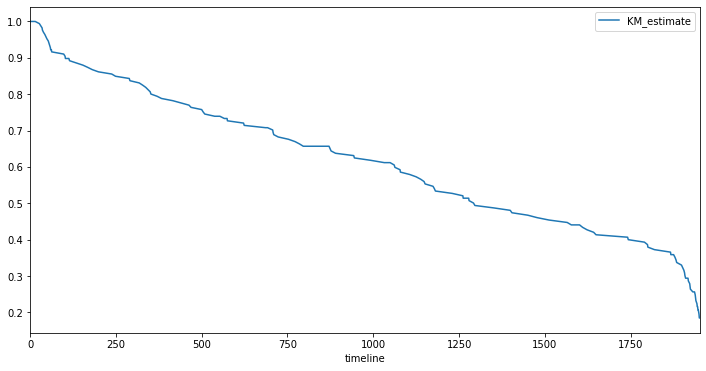

In [957]:
kmf.fit(T,C)
%pylab inline
figsize(12,6)
kmf.plot
kmf.survival_function_.plot()

In [958]:
fs_types = fs['CustId'].unique()
fs_types

array(['cust_id_1028', 'cust_id_1051', 'cust_id_1066', 'cust_id_1103',
       'cust_id_1113', 'cust_id_1130', 'cust_id_1133', 'cust_id_1177',
       'cust_id_120', 'cust_id_1203', 'cust_id_125', 'cust_id_1253',
       'cust_id_1276', 'cust_id_129', 'cust_id_1369', 'cust_id_1422',
       'cust_id_150', 'cust_id_1508', 'cust_id_1525', 'cust_id_153',
       'cust_id_1584', 'cust_id_1586', 'cust_id_160', 'cust_id_1604',
       'cust_id_1610', 'cust_id_1615', 'cust_id_1619', 'cust_id_1621',
       'cust_id_1634', 'cust_id_1635', 'cust_id_1665', 'cust_id_1700',
       'cust_id_1712', 'cust_id_1737', 'cust_id_178', 'cust_id_1792',
       'cust_id_1798', 'cust_id_1845', 'cust_id_1848', 'cust_id_1870',
       'cust_id_1889', 'cust_id_1918', 'cust_id_1924', 'cust_id_1929',
       'cust_id_2000', 'cust_id_2018', 'cust_id_2039', 'cust_id_2053',
       'cust_id_2071', 'cust_id_2082', 'cust_id_2110', 'cust_id_2132',
       'cust_id_2137', 'cust_id_2166', 'cust_id_221', 'cust_id_2234',
       'cust_i

ValueError: num must be 1 <= num <= 78, not 79

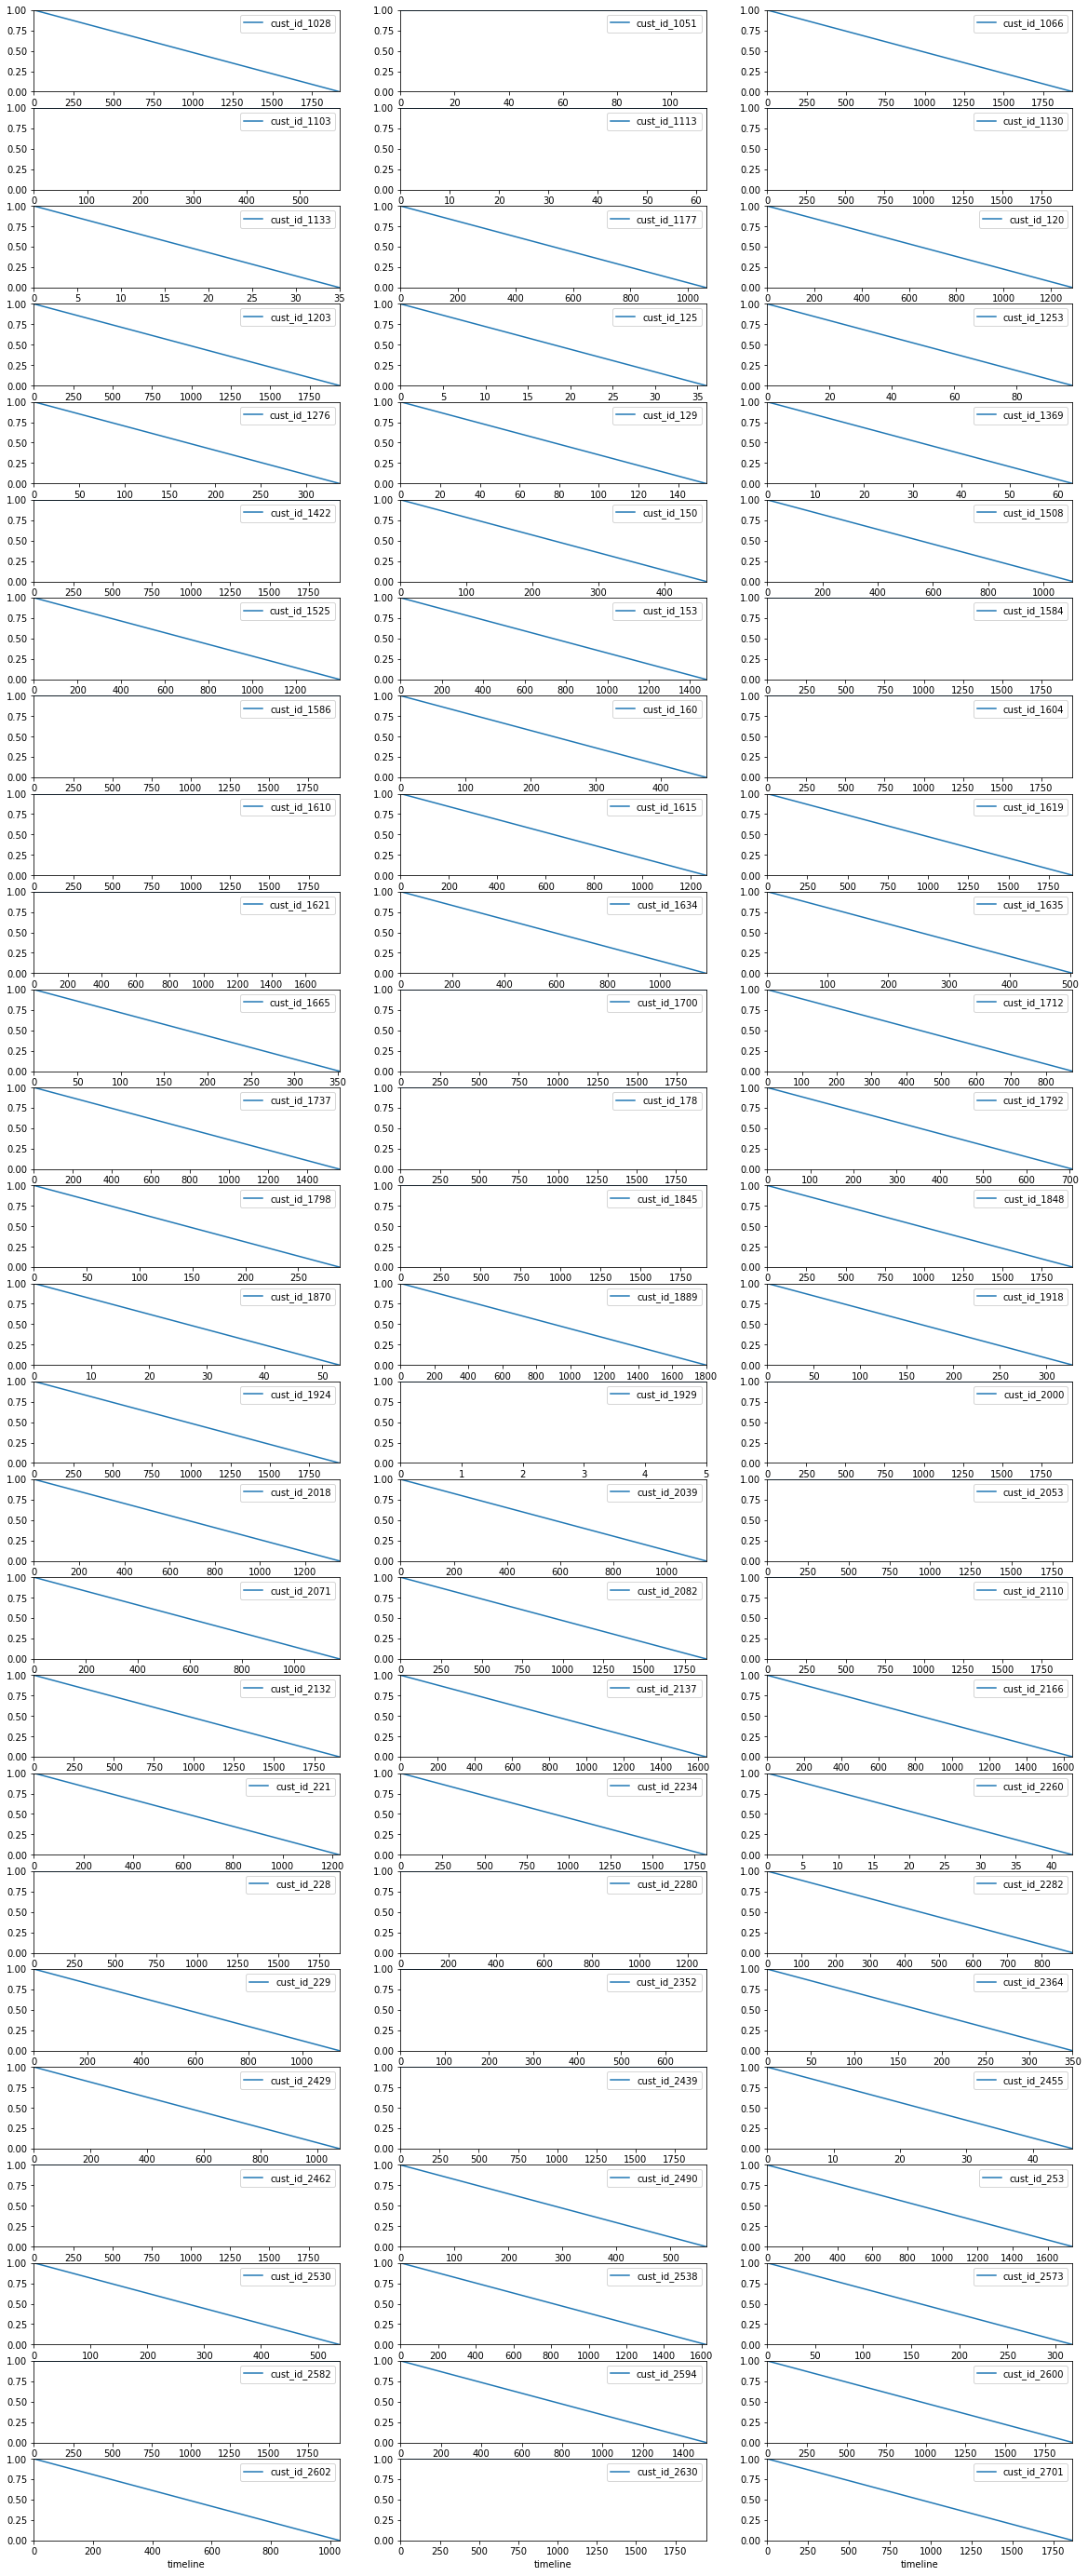

In [959]:
fs_types = fs['CustId'].unique()
fs_types
ii=0
plt.figure(figsize=(20,50))
for i in fs['CustId'].unique():
    ax = plt.subplot(26, 3, ii + 1)
    jj=fs['CustId']==i
    kmf.fit(T[jj],C[jj],label=i)
    ax=kmf.survival_function_.plot(ax=ax)
    ii=ii+1
    plt.ylim(0, 1);
plt.tight_layout() 